In [1]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import gridspec
import matplotlib.dates as mdates

import tkp.db
import tkp.config
import logging
import csv
import time
import sys
import itertools

import numpy as np
import pandas as pd
import scipy as sp

from astropy import units as u
from astropy.coordinates import SkyCoord

import numbers
import math
import scipy
from scipy.stats import norm
from scipy.stats import sem
from scipy import linspace
from scipy import pi,sqrt,exp
from scipy.special import erf

import pylab

from matplotlib.ticker import NullFormatter
from matplotlib.font_manager import FontProperties

plt.rcParams['font.size']=16
plt.rcParams['axes.labelsize']='large'
plt.rcParams['axes.titlesize']='large'
pylab.rcParams['legend.loc'] = 'best'

%matplotlib inline

logging.basicConfig(level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xa

/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [2]:
def nsf(num, n=1):
    """n-Significant Figures"""
    numstr = ("{0:.%ie}" % (n-1)).format(num)
    return float(numstr)

def num_err(num, err, n=1):
    '''Return number rounded based on error'''
    return np.around(num,int(-(np.floor(np.log10(nsf(err,n=n)))))), nsf(err,n=n)

def clip(data, sigma=3):
    """Remove all values above a threshold from the array.
    Uses iterative clipping at sigma value until nothing more is getting clipped.
    Args:
        data: a numpy array
    """
    data = data[np.isfinite(data)]
    raveled = data.ravel()
    median = np.median(raveled)
    std = np.nanstd(raveled)
    newdata = raveled[np.abs(raveled-median) <= sigma*std]
    if len(newdata) and len(newdata) != len(raveled):
        return clip(newdata, sigma)
    else:
        return newdata


In [3]:
def dump_trans(dbname, dataset_id, engine, host, port, user, pword):
    tkp.db.Database(
        database=dbname, user=user, password=pword,
        engine=engine, host=host, port=port
    )

    # find all the new, candidate transient, sources detected by the pipeline
    transients_query = """
    SELECT  tr.runcat
           ,tr.newsource_type
           ,im.rms_min
           ,im.rms_max
           ,im.detection_thresh
           ,ex.f_int
    FROM newsource tr
         ,image im
         ,extractedsource ex
    WHERE tr.previous_limits_image = im.id
      AND tr.trigger_xtrsrc = ex.id
    """
    
    cursor = tkp.db.execute(transients_query, (dataset_id,))
    transients = tkp.db.generic.get_db_rows_as_dicts(cursor)
    print "Found", len(transients), "new sources"
    return transients, sources

def dump_sources(dbname, dataset_id, engine, host, port, user, pword):
    tkp.db.Database(
        database=dbname, user=user, password=pword,
        engine=engine, host=host, port=port
    )
    # extract the properties and variability parameters for all the running catalogue sources in the dataset
    sources_query = """\
    SELECT  im.taustart_ts
            ,im.tau_time
            ,ex.f_int
            ,ex.f_int_err
            ,ax.xtrsrc
            ,ex.extract_type
            ,rc.id as runcatid
            ,rc.dataset
            ,ex.ra
            ,ex.decl
            ,rc.wm_ra
            ,rc.wm_decl
            ,ex.ra_err
            ,ex.decl_err
            ,im.band
            ,ax.v_int
            ,ax.eta_int
            ,ax.f_datapoints
            ,im.freq_eff
    FROM extractedsource ex
         ,assocxtrsource ax
         ,image im
         ,runningcatalog rc
         ,runningcatalog_flux rf
    WHERE rf.runcat = rc.id
      and ax.runcat = rc.id
      AND ax.xtrsrc = ex.id
      and ex.image = im.id
      AND rc.dataset = %s
      ORDER BY rc.id
    """
    cursor = tkp.db.execute(sources_query, (dataset_id,))
    sources = tkp.db.generic.get_db_rows_as_dicts(cursor)

    print "Found", len(sources), "source datapoints"

    return sources 

In [4]:
def distSquared(p0, p1):
    distance  = np.sqrt((p0[0] - p1[0,:])**2 + (p0[1] - p1[1,:])**2)
    if np.min(distance) < 3.0:
        return np.where(distance == np.min(distance))[0]
    else:
        return None
    
def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

In [5]:
def retrieve_source(full_data, run_id):
    source_df = full_data[(full_data.runcatid == run_id)]
    
#     source_df = source_df.groupby('taustart_ts', as_index=False)
#     source_df.set_index(source_df.taustart_ts, inplace=True)
    return source_df


def plot_lightcurve(full_data, run_id, ion_sub=False, roll_len = 1*60, roll_type = 'triang', stdout=True):

    source_df = full_data[(full_data.runcatid == run_id)]
    if stdout:
        print source_df.wm_ra.iloc[0], source_df.wm_decl.iloc[0]

    pd.to_datetime(source_df.taustart_ts)
    source_df = source_df.groupby('taustart_ts', as_index=False).mean()
    source_df.set_index(source_df.taustart_ts, inplace=True)

    if ion_sub:
        rolling = source_df.f_int.rolling(roll_len, win_type=roll_type)
        source_df.f_int = source_df.f_int-rolling.mean()


    plt.rcParams['font.size']=16
    plt.rcParams['axes.labelsize']='large'
    plt.rcParams['axes.titlesize']='large'
    pylab.rcParams['legend.loc'] = 'best'

    ylim = [np.nanmean(source_df.f_int)-6.0*np.nanstd(source_df.f_int),
            np.nanmean(source_df.f_int)+10.0*np.nanstd(source_df.f_int)]



    myFmt = mdates.DateFormatter('%H:%M')
    source_df["taustart_ts"] = pd.to_datetime(source_df["taustart_ts"])
    obs_dates = np.unique([100*x.month+x.day for x in source_df["taustart_ts"]])

    n_hours = np.array([]) 
    for i in obs_dates:
        index = (100*pd.DatetimeIndex(source_df["taustart_ts"]).month+pd.DatetimeIndex(source_df["taustart_ts"]).day == i)# & (source_df.extract_type == 0)
        n_hours = np.append(n_hours, len(np.unique(pd.DatetimeIndex(source_df["taustart_ts"][index]).hour)))
    hour_ratio = [i/n_hours.sum() for i in n_hours ]
    gs_ratio = np.append((hour_ratio)/min(hour_ratio),1)

    gs = gridspec.GridSpec(1, len(obs_dates)+1, width_ratios=gs_ratio) 

    figcount = 0
    figure = plt.figure(figsize=(4*len(obs_dates),6))

    for i in obs_dates:
        index = (100*pd.DatetimeIndex(source_df["taustart_ts"]).month+pd.DatetimeIndex(source_df["taustart_ts"]).day == i)# & (source_df.extract_type == 0)
        ax = plt.subplot(gs[figcount])
        ax.locator_params(nticks=6)
        ax.errorbar(source_df["taustart_ts"].values[index],
                    source_df["f_int"].values[index],
                    yerr=source_df["f_int_err"].values[index],
                    fmt=".",c="#1f77b4",ecolor="#ff7f0e")

        if figcount > 0:
            ax.set_yticks([])
        if figcount ==0:
            plt.ylabel("Flux [Jy]")
            ax.yaxis.set_ticks_position('left')
        if stdout:
            print source_df["taustart_ts"].values[index][0]
        plt.annotate("{}-{}".format(pd.DatetimeIndex(source_df["taustart_ts"].values[index]).day[0],
                                    pd.DatetimeIndex(source_df["taustart_ts"].values[index]).month[0]),
                                    xy=(0.95,0.95), xycoords='axes fraction',
                                    horizontalalignment='right', verticalalignment='top',fontsize=16)

        plt.xticks(rotation=90)
        ax.set_ylim(ylim)
        ax.xaxis.set_major_formatter(myFmt)
        figcount+=1

    hist_index = np.isfinite(source_df["f_int"]) #& (source_df.extract_type == 0)
    plt.subplot(gs[figcount])
    (mu, sigma) = norm.fit(source_df["f_int"].iloc[hist_index].values)
    n, bins, patches   =  plt.hist(source_df["f_int"].values[hist_index],
                                   bins=100,normed=1, orientation='horizontal',facecolor="#1f77b4")
    y = mlab.normpdf( bins, mu, sigma)
    if stdout:
        print "Gaus fit: mu {}, sigma {}".format(round(mu,3),round(sigma,3))
    
    l = plt.plot(y,bins,'r--', linewidth=2)
    # plt.title("Source: N = {}".format(len(source_df["f_int"].values[np.isfinite(source_df["f_int"])])))
    plt.annotate("Total N:\n{}".format(len(source_df["f_int"].values[hist_index])),
                                xy=(0.95,0.95), xycoords='axes fraction',
                                horizontalalignment='right', verticalalignment='top',fontsize=16)
    # plt.ylabel("Normalized N")
    plt.yticks([])
    plt.ylim(ylim)
    plt.xticks(rotation=90)

    plt.subplots_adjust(wspace=0.1, hspace=0)
    return figure
#     plt.show()
# fig.text(0.5, 0.04, 'date', ha='center')
# plt.tight_layout()
# print(source_df["wm_ra"].values[0],source_df["wm_decl"].values[1])
# plt.savefig("{}_multiday_lightcurve.png".format(key))



In [6]:
engine = 'postgresql'
host = 'ads001'
port = 5432
user = 'mkuiack'
password = 'Morecomplicatedpass1234'
# database = 'raw_16SB'
# database = 'flux_16SB'
# database = 'fluxcal_db'

# databases = ['higher_201702250130','lower_201702250130']
query_loglevel = logging.WARNING  # Set to INFO to see queries, otherwise WARNING

## Load single database 

In [7]:
# db._configured = False
# del data
t1 = time.time()
dbname = "_201702250130"

print "database name: ",  dbname
logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)

db = tkp.db.Database(engine=engine, host=host, port=port,
                     user=user, password=password, database=dbname)

db.connect()
session = db.Session()
sources = dump_sources(dbname,2, engine, host, port, user, password)
print len(sources)
data = pd.DataFrame(sources).groupby("xtrsrc").last()

del sources

data.taustart_ts = pd.to_datetime(data.taustart_ts)

bool_index = [x.year == 2018 for x in data.taustart_ts]
data = data.drop(data.index[bool_index])
data = data.drop(data.index[np.abs(data.f_int) > 10e6])
data = data.drop(data.index[(data.set_index("taustart_ts").index.month != 2) & \
                           (data.set_index("taustart_ts").index.hour == 14)])

del bool_index

db._configured = False
del db, session

print time.time() - t1, "seconds."

INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/_201702250130
INFO:tkp.db.database:connecting to database...


database name:  _201702250130
Found 6742435 source datapoints
6742435


## Load multiple databases.

In [19]:
# db._configured = False
# del data
data = pd.DataFrame([])

for dbname in databases:
    print "database name: ",  dbname

    logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)
    
    db = tkp.db.Database(engine=engine, host=host, port=port,
                         user=user, password=password, database=dbname)
    db.connect()
    session = db.Session()

    sources = dump_sources(dbname,1, engine, host, port, user, password)

    if len(data) == 0:
        data = pd.DataFrame(sources)
        del sources
        data.taustart_ts = pd.to_datetime(data.taustart_ts)
        data.band = np.ones(len(data.band), dtype=int)

    else:
        new_data = pd.DataFrame(sources)
        del sources

        new_data.taustart_ts = pd.to_datetime(new_data.taustart_ts)
        new_data.runcatid += data.runcatid.iloc[-1]
        new_data.band = (data.band.iloc[-1]+1)*np.ones(len(new_data.band), dtype=int)

        data = pd.concat([data,new_data], ignore_index=True)
        del new_data
        
    db._configured = False
    del db, session

NameError: name 'databases' is not defined

#### Save all data

In [ ]:
all_data_name = "all_raw_data.csv"
data.to_csv(all_data_name, index=True)

#### Load all data

In [ ]:
all_data_name = "fb_flux_all_raw_data.csv"
data = pd.read_csv(all_data_name, infer_datetime_format=True)

## Clean Catalogue

In [20]:
# Detection in both subbands, simultaneously, in > N_detections timesteps. 

N_detections = 0 


# multi_detections = [] 
reduced = pd.DataFrame([])


t1 = time.time()
for _id in np.unique(data.runcatid):
    if len(data[(data.runcatid == _id) & \
                (data.band == 23) & \
                (data.extract_type == 0)].set_index("taustart_ts").index.\
           intersection(data[(data.runcatid == _id) & \
                             (data.band == 24) & \
                             (data.extract_type == 0)].set_index("taustart_ts").index )) > N_detections:
        
#         multi_detections.append(run_index)
        if len(reduced) == 0:
            reduced = pd.DataFrame(data[(data.runcatid == _id)])
        else:
            reduced = pd.concat([reduced,data[(data.runcatid == _id)]])

print time.time() - t1

AttributeError: 'DataFrame' object has no attribute 'runcatid'

In [10]:
base = reduced.groupby("runcatid").mean()

In [76]:
print len(multi_detections), len(np.unique(data.runcatid))

1051 2586


In [13]:
# reduced_low = pd.DataFrame([])
# reduced_hi = pd.DataFrame([])

reduced = pd.DataFrame([])

for _id in multi_detections:
#     if len(reduced_low) == 0:
#         reduced_low = pd.DataFrame(data[(data.runcatid == _id) & \
#                                        (data.band == 23)])
#         reduced_hi = pd.DataFrame(data[(data.runcatid == _id) & \
#                                        (data.band == 24)])
#     else:
#         reduced_low = pd.concat([reduced_low,data[(data.runcatid == _id) & \
#                                        (data.band == 23)]])
#         reduced_hi = pd.concat([reduced_hi,data[(data.runcatid == _id) & \
#                                        (data.band == 24)]])
 
    if len(reduced) == 0:
        reduced = pd.DataFrame(data[(data.runcatid == _id)])
    else:
        reduced = pd.concat([reduced,data[(data.runcatid == _id)]])

## Match catalogues

In [8]:
high_ra, index = np.unique(data[data.band ==1].wm_ra, return_index=True)
high_dec = data[data.band ==1].wm_decl.iloc[index]
high_id = data[data.band ==1].wm_decl.iloc[index]

low_ra, index = np.unique(data[data.band == 2].wm_ra, return_index=True)
low_dec = data[data.band == 2].wm_decl.iloc[index]
low_id = data[data.band == 2].wm_decl.iloc[index]

higher = SkyCoord(high_ra*u.degree, dec=high_dec*u.degree)
lower = SkyCoord(ra=low_ra*u.degree, dec=low_dec*u.degree)

idx, d2d, d3d = lower.match_to_catalog_sky(higher) 




NotImplementedError: cannot make a list of Quantities.  Get list of values with q.value.list()

In [9]:
np.unique(data[data.band ==1].wm_ra, return_index=True)

(array([   1.53087907,    1.83466003,    2.81634345, ...,  359.02810232,
         359.03345382,  359.0841849 ]),
 array([947794, 974964, 975630, ..., 467352, 601253, 604034]))

In [16]:
higher = SkyCoord(ra=np.array(data.ra, dtype=float)*u.degree,
                  dec=np.array(data.decl, dtype=float)*u.degree)

In [30]:
higher = SkyCoord(ra=(data[data.band == 1].ra*u.degree).values, dec=(data[data.band == 1].decl*u.degree).values)
lower = SkyCoord(ra=(data[data.band == 2].ra*u.degree).values, dec=(data[data.band == 2].decl*u.degree).values)

idx, d2d, d3d = lower.match_to_catalog_sky(higher)

In [58]:
source_df.f_int_err[source_df.band == i]

taustart_ts
2017-02-25 01:32:30    6.549283
2017-02-25 01:33:39    6.132424
2017-02-25 01:33:46    6.991820
2017-02-25 01:34:26    6.428406
2017-02-25 01:34:28    6.182589
2017-02-25 01:34:40    6.838728
2017-02-25 01:34:47    6.594671
2017-02-25 01:34:49    6.350735
2017-02-25 01:36:08    6.532712
2017-02-25 01:36:09    5.836730
2017-02-25 01:36:12    6.460664
2017-02-25 01:36:33    5.889345
2017-02-25 01:36:36    6.139827
2017-02-25 01:36:38    6.514697
2017-02-25 01:36:41    6.521776
2017-02-25 01:38:26    6.464316
2017-02-25 01:38:28    6.256084
2017-02-25 01:38:38    6.570213
2017-02-25 01:38:39    6.428659
2017-02-25 01:38:41    6.594022
2017-02-25 01:38:43    7.076092
2017-02-25 01:40:24    7.046392
2017-02-25 01:40:26    6.382788
2017-02-25 01:40:27    6.578089
2017-02-25 01:40:28    6.771302
2017-02-25 01:40:29    6.628641
2017-02-25 01:40:56    6.833730
2017-02-25 01:40:57    6.331782
2017-02-25 01:40:58    6.509497
2017-02-25 01:41:00    6.678663
                         ...

In [8]:
source_df = retrieve_source(data, 300)
# source_df = source_df[source_df.index.year == 2017]


In [9]:
plt.errorbar(source_df.taustart_ts[source_df.band == i].values,source_df.f_int[source_df.band == i].values, 
                 yerr = source_df.f_int_err[source_df.band == i].values)


NameError: name 'i' is not defined

In [10]:
print min(data.runcatid)
print max(data.runcatid)

160
2768


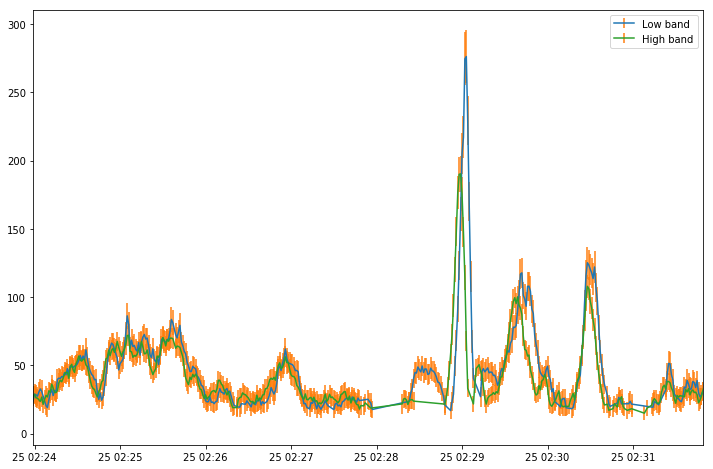

In [223]:
%matplotlib inline

source_df = retrieve_source(data, 161)

# plt.figure(figsize=(24,8))
# for i in np.unique(source_df.band):
#     plt.plot(source_df.taustart_ts[source_df.band == i],
#                  source_df.f_int[source_df.band == i], ".-", label="Band: {}".format(i)  )

plt.figure(figsize=(12,8))
plt.errorbar(source_df.taustart_ts[source_df.freq_eff < 60000000].values,
             source_df.f_int[source_df.freq_eff < 60000000].values, 
             yerr = source_df.f_int_err[source_df.freq_eff < 60000000].values,
             fmt="-",ecolor="C1", label="Low band")

# plt.errorbar(source_df.taustart_ts[(source_df.freq_eff < 60000000) & (source_df.extract_type == 1 )].values,
#              source_df.f_int[(source_df.freq_eff < 60000000) & (source_df.extract_type == 1 )].values, 
#              yerr = source_df.f_int_err[(source_df.freq_eff < 60000000) & (source_df.extract_type == 1 )].values,
#              fmt="o", color="C2",ecolor="C1")

# plt.ylim([0,80])

# plt.figure(figsize=(24,8))
plt.errorbar(source_df.taustart_ts[source_df.freq_eff > 60000000].values,
             source_df.f_int[source_df.freq_eff > 60000000].values, 
             yerr = source_df.f_int_err[source_df.freq_eff > 60000000].values,
             fmt="-",color="C2", ecolor="C1", label="High band")

# plt.errorbar(source_df.taustart_ts[(source_df.freq_eff > 60000000) & (source_df.extract_type == 1 )].values,
#              source_df.f_int[(source_df.freq_eff > 60000000) & (source_df.extract_type == 1 )].values, 
#              yerr = source_df.f_int_err[(source_df.freq_eff > 60000000) & (source_df.extract_type == 1 )].values,
#              fmt="-", color="C2",ecolor="C1")



plt.xlim([source_df.taustart_ts[source_df.freq_eff > 60000000].values[-623],
         source_df.taustart_ts[source_df.freq_eff > 60000000].values[-223]])

plt.legend()

In [209]:
plt.plot(source_df.f_int[source_df.freq_eff > 60000000].values/ source_df.f_int[source_df.freq_eff < 60000000].values, ".")

ValueError: operands could not be broadcast together with shapes (3810,) (3754,) 

(736385.099988426, 736385.1054282407)

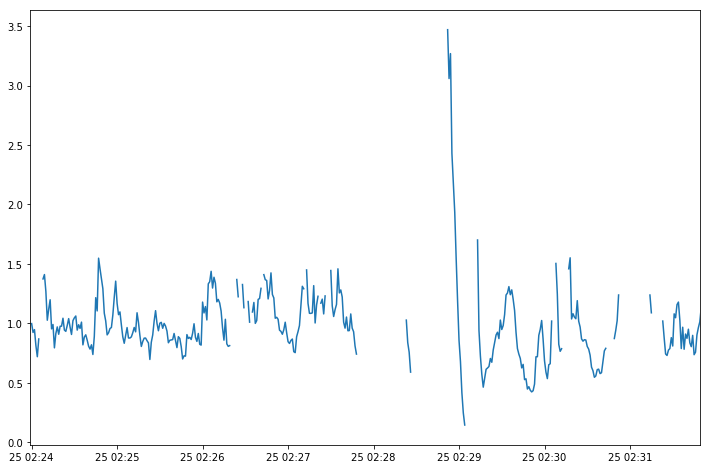

In [224]:
plt.figure(figsize=(12,8))
plt.plot(source_df[source_df.freq_eff > 60000000].set_index("taustart_ts").f_int/source_df[source_df.freq_eff < 60000000].set_index("taustart_ts").f_int)
plt.xlim([source_df.taustart_ts[source_df.freq_eff > 60000000].values[-623],
         source_df.taustart_ts[source_df.freq_eff > 60000000].values[-223]])

In [179]:
data = data.drop(data.index[data.f)int == np.max(data.taustart_ts)])

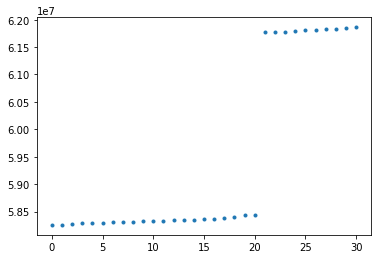

In [132]:
plt.plot(np.unique(data.freq_eff), ".")

data = data.drop(data.index[np.abs(data.f_int) > 10e6])

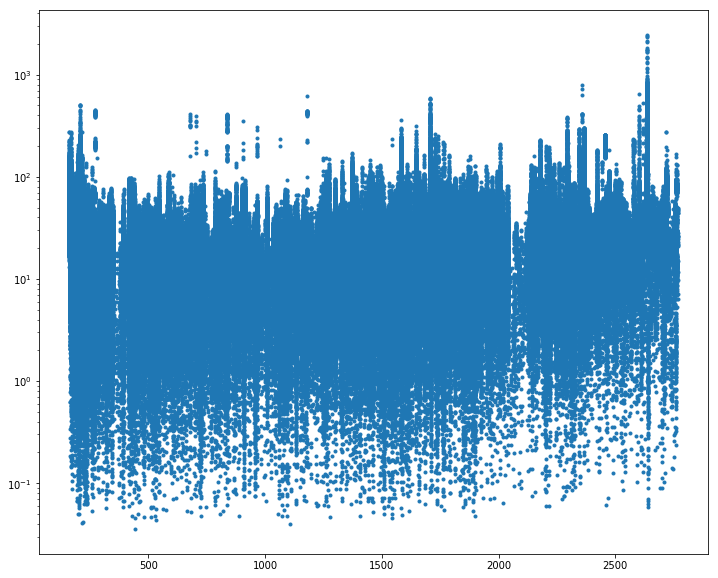

In [118]:
plt.figure(figsize=(12,10))
plt.plot(data.runcatid[data.f_int < 10e5], data.f_int[data.f_int < 10e5], ".")
plt.yscale("log")

In [100]:
np.where(source_df.index.year ==2018)

(array([], dtype=int64),)

In [103]:
data[data.runcatid == 1].wm_ra.iloc[0], data[data.runcatid == 1].wm_decl.iloc[0]

(247.186254743988, 39.399400295862399)

In [108]:
p1 = SkyCoord(ra=(data[data.runcatid == 1].wm_ra.iloc[0]*u.degree),
                  dec=(data[data.runcatid == 1].wm_decl.iloc[0]*u.degree))
lower

<SkyCoord (ICRS): (ra, dec) in deg
    [(  2.47228349e+02,  39.36173231), (  2.47229999e+02,  39.38646435),
     (  2.47059419e+02,  39.41649621), ...,
     (  2.13972986e+02,  29.16307307), (  2.14041150e+02,  29.13051157),
     (  2.14106122e+02,  29.15144207)]>

In [112]:
data[data.band == 2][p1.separation(lower) < 1*u.degree]

,band,dataset,decl,decl_err,eta_int,extract_type,f_datapoints,f_int,f_int_err,freq_eff,ra,ra_err,runcatid,tau_time,taustart_ts,v_int,wm_decl,wm_ra,xtrsrc
976110,2,1,39.361732,0.094313,6.916444,0,8338,27.719405,7.801233,58300780.0,247.228349,0.125698,1436,1.0,2017-02-25 03:52:01,-3774.611363,39.389354,247.185655,679637
976111,2,1,39.386464,0.063497,5.280496,0,12652,41.296534,7.394331,58398436.0,247.229999,0.080372,1436,1.0,2017-02-25 05:04:25,293.025540,39.389354,247.185655,990833
976112,2,1,39.416496,0.087824,7.619593,0,1146,30.625091,8.697310,58300780.0,247.059419,0.124342,1436,1.0,2017-02-25 01:49:22,33.849953,39.389354,247.185655,90336
976113,2,1,39.507698,0.064061,7.276207,0,7482,45.161754,8.799439,58300780.0,247.159158,0.087084,1436,1.0,2017-02-25 03:37:39,-3569.042293,39.389354,247.185655,626095
976114,2,1,39.336266,0.063424,6.921881,0,8317,45.964468,8.697977,58300780.0,247.266272,0.084522,1436,1.0,2017-02-25 03:51:40,-3769.754660,39.389354,247.185655,678338
976115,2,1,39.396776,0.058862,5.290685,0,12621,44.288620,7.351955,58398436.0,247.246765,0.074535,1436,1.0,2017-02-25 05:03:54,292.667199,39.389354,247.185655,988856
976116,2,1,39.387400,0.069417,5.208353,0,12862,42.100772,8.233360,58346356.0,247.303457,0.087777,1436,1.0,2017-02-25 05:07:57,295.441337,39.389354,247.185655,1004344
976117,2,1,39.435415,0.029826,7.440287,0,3534,67.814379,7.070802,58320312.0,247.106497,0.046193,1436,1.0,2017-02-25 02:29:57,-2433.358354,39.389354,247.185655,294611
976118,2,1,39.459537,0.044953,8.036622,0,2502,43.147697,7.063492,58346356.0,247.121276,0.072149,1436,1.0,2017-02-25 02:12:38,-2043.132334,39.389354,247.185655,203992
976119,2,1,39.331745,0.041637,7.824147,0,6463,83.686397,10.868318,58300780.0,247.180481,0.057871,1436,1.0,2017-02-25 03:20:28,-3310.543269,39.389354,247.185655,552465


In [14]:
reduced_low = data[data.band == 23].groupby("runcatid").mean()
reduced_hi = data[data.band == 24].groupby("runcatid").mean()

In [10]:
%matplotlib inline

plt.figure(figsize=(24,20))

plt.scatter(reduced[reduced.band == 23].groupby("runcatid").first().wm_ra, 
            reduced[reduced.band == 23].groupby("runcatid").first().wm_decl,
            facecolors='none', edgecolors='r',
           s=15)

plt.scatter(reduced[reduced.band == 24].groupby("runcatid").first().wm_ra, 
            reduced[reduced.band == 24].groupby("runcatid").first().wm_decl,
            c="black",
           s=5)

NameError: name 'reduced' is not defined

In [59]:
len(np.unique(reduced.runcatid))

1051

In [40]:
band1 = SkyCoord(ra=(reduced[reduced.band == 1].wm_ra*u.degree).values,
                dec=(reduced[reduced.band == 1].wm_decl*u.degree).values)

band2 = SkyCoord(ra=(reduced[reduced.band == 2].wm_ra*u.degree).values,
                dec=(reduced[reduced.band == 2].wm_decl*u.degree).values)


In [37]:
for i in band1:
    for j in band2:
        if j.lower.match_to_catalog_sky(higher)

<SkyCoord (ICRS): (ra, dec) in deg
    [( 247.18625474,  39.3994003 ), ( 230.18456511,  20.04971211),
     ( 260.93923596,  50.83740648), ..., ( 289.99997387,  74.42867236),
     ( 269.84725218,  46.03556422), ( 287.26150892,  26.98088046)]>

In [43]:
idx1, sep1, d3d1 = band1.match_to_catalog_sky(band2)

In [44]:
idx2, sep2, d3d2 = band2.match_to_catalog_sky(band1)

<IPython.core.display.Javascript object>


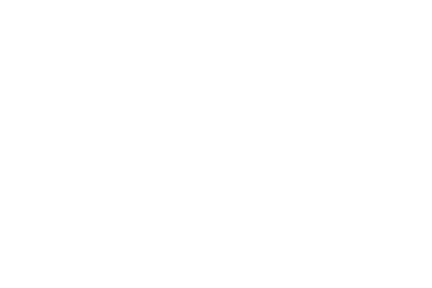

<IPython.core.display.Javascript object>


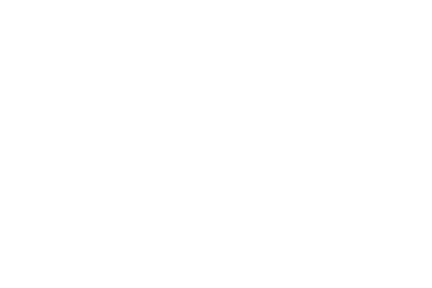

In [40]:
hist = plt.hist(reduced.f_int, bins=100,log=True)


In [39]:
reduced[reduced.band == 2].iloc[6].ra


237.29583399571379

In [55]:
i = 5

print idx1[i],idx2[i]

6 67


In [53]:
np.unique(data.runcatid, return_index=True )[1]

array([      0,     466,   21318, ..., 6322090, 6322122, 6322186])

In [54]:
reduced = data.iloc[np.unique(data.runcatid, return_index=True )[1]]

In [100]:
data[data.runcatid == 160]

,band,dataset,decl,decl_err,eta_int,extract_type,f_datapoints,f_int,f_int_err,freq_eff,ra,ra_err,runcatid,tau_time,taustart_ts,v_int,wm_decl,wm_ra,xtrsrc
0,23,2,13.575972,0.138752,0.089614,0,61,20.308833,6.762343,61816408.0,145.892648,0.136471,160,1.0,2017-02-25 01:36:14,0.095596,13.618078,145.809975,63288
1,24,2,13.669865,0.125002,0.212004,0,129,18.024957,5.416340,58300780.0,145.859241,0.123152,160,1.0,2017-02-25 01:36:15,0.137115,13.618078,145.809975,63422
2,24,2,13.647891,0.135330,0.216239,0,130,16.950349,5.514295,58300780.0,145.809621,0.133401,160,1.0,2017-02-25 01:36:18,0.138354,13.618078,145.809975,63919
3,24,2,13.556093,0.123966,0.215958,0,131,19.282390,5.735331,58300780.0,145.832763,0.121991,160,1.0,2017-02-25 01:36:20,0.138394,13.618078,145.809975,64241
4,24,2,13.636268,0.143943,0.220440,0,132,16.547213,5.724116,58300780.0,145.862893,0.141815,160,1.0,2017-02-25 01:36:21,0.139827,13.618078,145.809975,64408
5,24,2,13.603691,0.141609,0.228766,0,133,15.543767,5.286593,58320312.0,145.863313,0.139449,160,1.0,2017-02-25 01:36:22,0.141916,13.618078,145.809975,64574
6,23,2,13.629798,0.133267,0.088303,0,62,20.418181,6.534866,61816408.0,145.969921,0.131111,160,1.0,2017-02-25 01:36:23,0.095036,13.618078,145.809975,64780
7,24,2,13.704397,0.125308,0.228254,0,134,19.244757,5.802303,58300780.0,145.837659,0.123610,160,1.0,2017-02-25 01:36:25,0.141913,13.618078,145.809975,65028
8,24,2,13.570758,0.116621,0.226675,0,135,22.371377,6.260916,58300780.0,145.864566,0.114778,160,1.0,2017-02-25 01:36:28,0.141372,13.618078,145.809975,65462
9,24,2,13.602535,0.097502,0.224997,0,136,21.500435,5.031826,58300780.0,145.881201,0.095967,160,1.0,2017-02-25 01:36:29,0.140879,13.618078,145.809975,65618


In [80]:
np.array([data[data.runcatid == 2681].extract_type == 0], dtype=bool) and  np.array([data[data.runcatid == 2681].band == 23], dtype=bool)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [152]:
(np.array([True, False, True, False]) * np.array([True, True, False, False])) * \
(np.array([True, False, True, False]) * np.array([True, True, False, False]))

array([ True, False, False, False], dtype=bool)

In [31]:
(data[(data.runcatid == run_index) & (data.extract_type == 0)].sort_values(by="taustart_ts")) * \
     (data[(data.runcatid == run_index) & (data.band == 23)].sort_values(by="taustart_ts"))

TypeError: ufunc multiply cannot use operands with types dtype('<M8[ns]') and dtype('<M8[ns]')

In [53]:

run_index = 1561
len(data[(data.runcatid == run_index) & \
     (data.band == 23) & \
     (data.extract_type == 0)].set_index("taustart_ts").index.\
intersection(data[(data.runcatid == run_index) & \
     (data.band == 24) & \
     (data.extract_type == 0)].set_index("taustart_ts").index )) > 0

False

In [39]:
np.array([True,True,True,True]) * np.array([False, True, False, True])

array([False,  True, False,  True], dtype=bool)

In [18]:
run_index = 170
(((data[data.runcatid == run_index].extract_type == 0) * \
        (data[data.runcatid == run_index].band == 24)) * \
        ((data[data.runcatid == run_index].extract_type == 0) * \
         (data[data.runcatid == run_index].band == 23))).any()

False

In [22]:
run_index = 170

((data[data.runcatid == run_index].sort_values(by="taustart_ts").extract_type == 0) * \
        (data[data.runcatid == run_index].sort_values(by="taustart_ts").band == 24)) * \
        ((data[data.runcatid == run_index].sort_values(by="taustart_ts").extract_type == 0) * \
         (data[data.runcatid == run_index].sort_values(by="taustart_ts").band == 23))

xtrsrc
8912       False
8950       False
8998       False
9033       False
9114       False
9149       False
9236       False
9304       False
9366       False
9397       False
9547       False
9509       False
9651       False
9680       False
9797       False
9833       False
9950       False
9983       False
10091      False
10130      False
10232      False
10269      False
10493      False
10376      False
10529      False
10565      False
10672      False
10714      False
10817      False
10853      False
           ...  
1393538    False
1394067    False
1398526    False
1398894    False
1399101    False
1401376    False
1402212    False
1402339    False
1402480    False
1402640    False
1402669    False
1403067    False
1403205    False
1403378    False
1403972    False
1404294    False
1404441    False
1404948    False
1406376    False
1406989    False
1408492    False
1409804    False
1409988    False
1410164    False
1410808    False
1412845    False
1424650    False
1465307

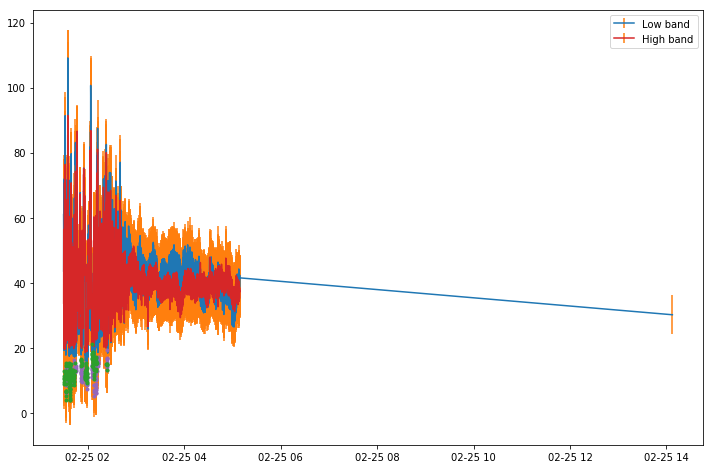

In [11]:

run_index = 197 #np.unique(reduced.runcatid)[653]

source_df = retrieve_source(reduced, run_index)

plt.figure(figsize=(12,8))
plt.errorbar(source_df.taustart_ts[(source_df.freq_eff < 60000000) & (source_df.extract_type == 0)].values,
             source_df.f_int[(source_df.freq_eff < 60000000) & (source_df.extract_type == 0)].values, 
             yerr = source_df.f_int_err[(source_df.freq_eff < 60000000) & (source_df.extract_type == 0)].values,
             fmt="-", color="C0",ecolor="C1", label="Low band")

plt.errorbar(source_df.taustart_ts[(source_df.freq_eff < 60000000) & (source_df.extract_type == 1 )].values,
             source_df.f_int[(source_df.freq_eff < 60000000) & (source_df.extract_type == 1 )].values, 
             yerr = source_df.f_int_err[(source_df.freq_eff < 60000000) & (source_df.extract_type == 1 )].values,
             fmt=".", color="C4",ecolor="C1")

# plt.ylim([0,80])

# plt.figure(figsize=(24,8))
plt.errorbar(source_df.taustart_ts[(source_df.freq_eff > 60000000) & (source_df.extract_type == 0 )].values,
             source_df.f_int[(source_df.freq_eff > 60000000) & (source_df.extract_type == 0 )].values, 
             yerr = source_df.f_int_err[(source_df.freq_eff > 60000000) & (source_df.extract_type == 0 )].values,
             fmt="-",color="C3", ecolor="C1", label="High band")

plt.errorbar(source_df.taustart_ts[(source_df.freq_eff > 60000000) & (source_df.extract_type == 1 )].values,
             source_df.f_int[(source_df.freq_eff > 60000000) & (source_df.extract_type == 1 )].values, 
             yerr = source_df.f_int_err[(source_df.freq_eff > 60000000) & (source_df.extract_type == 1 )].values,
             fmt=".", color="C2",ecolor="C1")


# plt.xlim([source_df.taustart_ts[source_df.freq_eff > 60000000].values[700],
#          source_df.taustart_ts[source_df.freq_eff > 60000000].values[830]])

plt.legend()

In [81]:
target_ra = 280
target_decl = 80
radius = 5.

base[(base.ra > target_ra-radius) & (base.ra < target_ra+radius) & \
    (base.decl > target_decl-radius) & (base.decl < target_decl+radius)]

,band,dataset,decl,decl_err,eta_int,extract_type,f_datapoints,f_int,f_int_err,freq_eff,ra,ra_err,tau_time,v_int,wm_decl,wm_ra
runcatid,,,,,,,,,,,,,,,,


,band,dataset,decl,decl_err,eta_int,extract_type,f_datapoints,f_int,f_int_err,freq_eff,ra,ra_err,tau_time,v_int,wm_decl,wm_ra
runcatid,,,,,,,,,,,,,,,,
2765,23.510204,2.0,39.958391,0.093746,2.481896,0.204082,25.010204,73.351651,18.70575,6.002790e+07,300.459477,0.124535,-332.479592,0.367582,39.932534,300.53327


In [ ]:
item = 909

plt.figure(figsize=(24,10))
plt.plot(data[(data.runcatid == multi_detections[item]) & (data.band == 23) & (data.extract_type == 0)].taustart_ts, 
         data[(data.runcatid == multi_detections[item]) & (data.band == 23) & (data.extract_type == 0)].f_int, ".", c="C0")

plt.plot(data[(data.runcatid == multi_detections[item]) & (data.band == 23) & (data.extract_type == 1)].taustart_ts, 
         data[(data.runcatid == multi_detections[item]) & (data.band == 23) & (data.extract_type == 1)].f_int, "+", c="C0")


plt.plot(data[(data.runcatid == multi_detections[item]) & (data.band == 24) & (data.extract_type == 0)].taustart_ts, 
         data[(data.runcatid == multi_detections[item]) & (data.band == 24) & (data.extract_type == 0)].f_int, ".", c="C1")
plt.plot(data[(data.runcatid == multi_detections[item]) & (data.band == 24) & (data.extract_type == 1)].taustart_ts, 
         data[(data.runcatid == multi_detections[item]) & (data.band == 24) & (data.extract_type == 1)].f_int, "+", c="C1")



In [197]:
unique_xtc = np.unique(data.xtrsrc)

In [206]:
data[data.xtrsrc == unique_xtc[200503]].sort_values(by="taustart_ts")

,band,dataset,decl,decl_err,eta_int,extract_type,f_datapoints,f_int,f_int_err,freq_eff,ra,ra_err,runcatid,tau_time,taustart_ts,v_int,wm_decl,wm_ra,xtrsrc
2916306,23,2,27.706732,0.154095,0.110877,1,264,16.395195,6.606272,61816408.0,194.915122,0.157955,689,1.0,2017-02-25 01:51:17,0.130101,27.645818,194.860155,209377
2931199,23,2,27.706732,0.154095,0.110877,1,264,16.395195,6.606272,61816408.0,194.915122,0.157955,689,1.0,2017-02-25 01:51:17,0.130101,27.645818,194.860155,209377


In [73]:
data = data.drop(data.index[(data.set_index("taustart_ts").index.month != 2)])

In [187]:
run_index

1569

In [181]:
data[data.runcatid == run_index].taustart_ts

4977206   2017-02-25 03:26:23
4977207   2017-02-25 03:26:22
4977208   2017-02-25 03:26:19
4977209   2017-02-25 03:26:18
4977210   2017-02-25 03:02:00
4977211   2017-02-25 03:46:41
4977212   2017-02-25 03:26:16
4977213   2017-02-25 02:57:41
4977214   2017-02-25 02:57:42
4977215   2017-02-25 02:57:42
4977216   2017-02-25 02:57:43
4977217   2017-02-25 02:57:44
4977218   2017-02-25 02:57:45
4977219   2017-02-25 02:57:45
4977220   2017-02-25 02:57:46
4977221   2017-02-25 02:57:46
4977222   2017-02-25 02:57:47
4977223   2017-02-25 02:57:47
4977224   2017-02-25 02:57:49
4977225   2017-02-25 02:57:49
4977226   2017-02-25 02:57:50
4977227   2017-02-25 02:57:50
4977228   2017-02-25 02:57:51
4977229   2017-02-25 02:57:51
4977230   2017-02-25 02:57:52
4977231   2017-02-25 02:57:53
4977232   2017-02-25 02:57:54
4977233   2017-02-25 03:26:14
4977234   2017-02-25 03:26:14
4977235   2017-02-25 03:26:13
                  ...        
4977518   2017-02-25 03:26:11
4977519   2017-02-25 03:26:12
4977520   